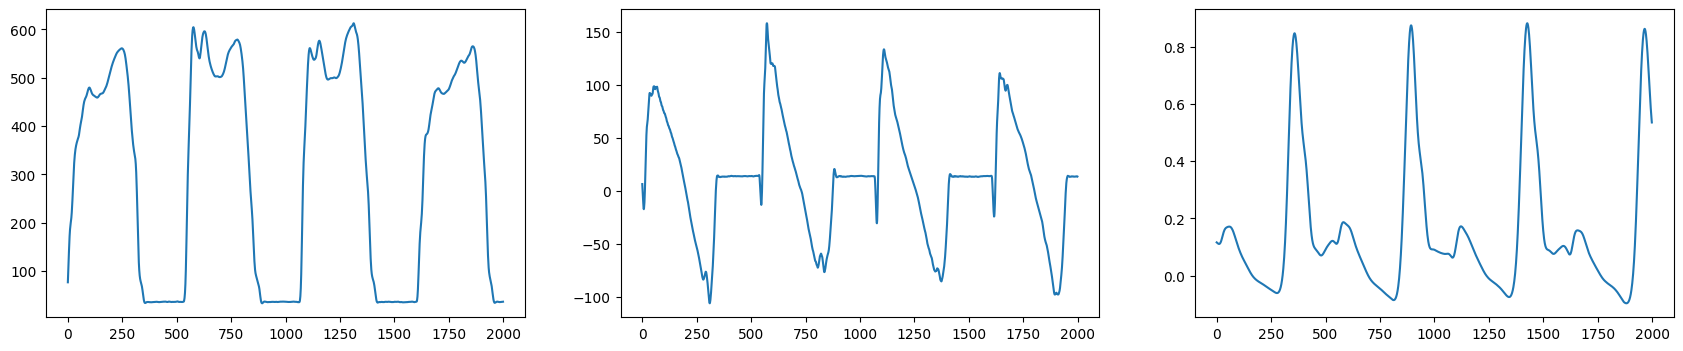

In [1]:
import scipy.io as scio
import numpy as np
from matplotlib import pyplot as plt

data = scio.loadmat("./adaptation_Day4/ADAPT1.mat")
data_list = np.zeros((4, len(data['posaL'])))
# print(type(data))
# print(data.keys())
# print(type(data['posaL'].shape))
# print(data['posaL'].shape)

data_list[0, :] = np.transpose(data['posaL'])
data_list[1, :] = np.transpose(data['velaL'])
data_list[2, :] = np.transpose(data['taudesL'])
data_list[3, :] = np.transpose(data['vco2'])
time_list = data['time'].squeeze()
forcez_list = data['LFz'].squeeze()
forcey_list = data['LFy'].squeeze()

p1, p2 = 100000, 102000
fig = plt.figure(num=3, figsize=[21, 4])
ax1 = fig.add_subplot(131)
ax1.plot(forcez_list[p1: p2])

ax2 = fig.add_subplot(132)
ax2.plot(forcey_list[p1: p2])

ax3 = fig.add_subplot(133)
ax3.plot(data_list[0, p1: p2])

plt.show()

(2500,)
(2439,)
(2431,)


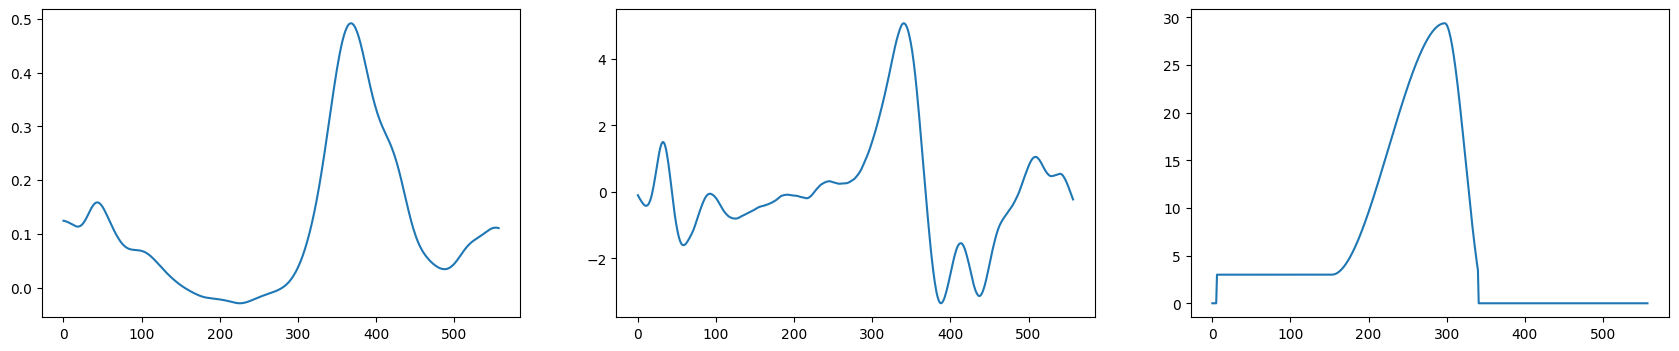

In [2]:
# 找出每个步态周期的起始点
gait_split_points = []
plain_count = 0
plain_value = 0
plain_threshold = 160
find_plain_flag = False
skip_flag = False
skip_count = 0
skip_threshold = 200

for i in range(len(forcez_list) - 2):
    if skip_flag and skip_count < skip_threshold:
        skip_count += 1
        continue
    else:
        skip_count = 0
        skip_flag = False
        
    if abs(forcez_list[i+1] - forcez_list[i]) < 1 and abs(forcez_list[i+2] - forcez_list[i+1]) < 1 and (not find_plain_flag):
        plain_count += 1
        if plain_count > plain_threshold:
            plain_count = 0
            plain_value = np.average(forcez_list[i-30: i])
            find_plain_flag = True
    elif find_plain_flag and forcez_list[i+1] - plain_value > 3:
        find_plain_flag = False
        skip_flag = True
        gait_split_points.append(i)

gait_split_points = np.array(gait_split_points)

# 去掉没有控制律的部分
print(gait_split_points.shape)
for i in range(len(gait_split_points)-1):
    torque_aver = np.average(data_list[2][gait_split_points[i]: gait_split_points[i+1]])
    # print(torque_aver)
    if torque_aver > 3 :
        gait_split_points = gait_split_points[i : -1]
        break

print(gait_split_points.shape)

for i in range(len(gait_split_points)-1, 0, -1):
    torque_aver = np.average(data_list[2][gait_split_points[i-1]: gait_split_points[i]])
    # print(torque_aver)
    if torque_aver > 3 :
        gait_split_points = gait_split_points[0: i]
        break
        
print(gait_split_points.shape)

p1, p2 = gait_split_points[len(gait_split_points)-2], gait_split_points[len(gait_split_points)-1]
fig = plt.figure(num=3, figsize=[21, 4])
ax1 = fig.add_subplot(131)
ax1.plot(data_list[0][p1: p2])

ax2 = fig.add_subplot(132)
ax2.plot(data_list[1][p1: p2])

ax3 = fig.add_subplot(133)
ax3.plot(data_list[2][p1: p2])

plt.show()

In [3]:
print(gait_split_points[0], gait_split_points[-1])

33328 1399423


2428


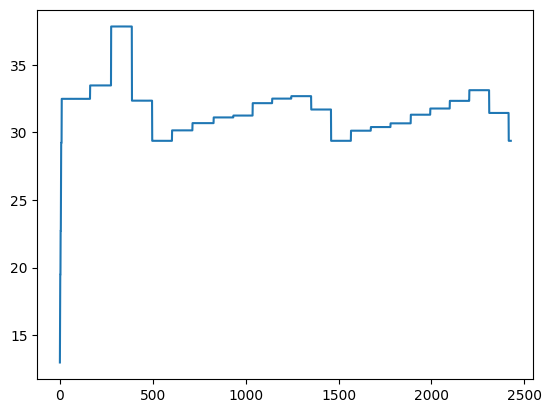

[12.99137437 16.23926743 19.48722682 19.4876789  22.73450487 22.73541346
 25.98343471 29.23150939 29.23142661 29.23133464 32.47888853 32.47940594
 32.47843728 32.47933768 32.47839023 32.47891657 32.4781734  32.47788973
 32.47799396 32.47892177]


In [4]:
src_torque = data_list[2, :]
peak_torque_value = []
peak_torque_points = []
for i in range(len(gait_split_points) - 3):
    peak_index = gait_split_points[i] + np.argmax(src_torque[gait_split_points[i]: gait_split_points[i+1]])
    peak_torque_value.append(src_torque[peak_index])
    peak_torque_points.append(peak_index)

peak_torque_value = np.array(peak_torque_value)
print(len(peak_torque_value))
plt.plot(peak_torque_value)
plt.show()
print(peak_torque_value[0: 20])

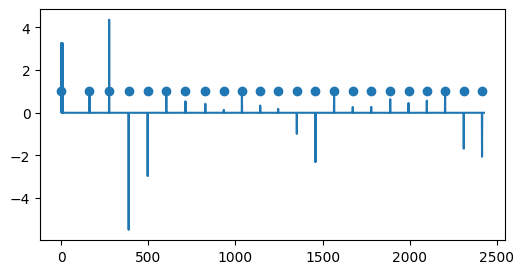

array([   0,  162,  275,  387,  496,  603,  713,  827,  933, 1037, 1142,
       1245, 1352, 1459, 1566, 1673, 1779, 1888, 1993, 2098, 2203, 2310,
       2415])

In [5]:
convert_points = peak_torque_value[1: len(peak_torque_value)] - peak_torque_value[0: len(peak_torque_value) - 1]

filter_convert_points = []
skip_count = 0
for i in range(len(convert_points)):
    if skip_count == 0 and abs(convert_points[i]) > 0.1:
        filter_convert_points.append(i)
        skip_count += 1
    if 0 < skip_count < 10:
        skip_count += 1
    else :
        skip_count = 0

filter_convert_points = np.array(filter_convert_points)

fig = plt.figure(num=1, figsize=[6, 3])
ax1 = fig.add_subplot(111)
ax1.plot(convert_points)
ax1.scatter(filter_convert_points, np.ones(len(filter_convert_points)))
plt.show()
filter_convert_points

In [19]:
peak_torque_points = np.array(peak_torque_points)
grade_split_points = peak_torque_points[filter_convert_points]

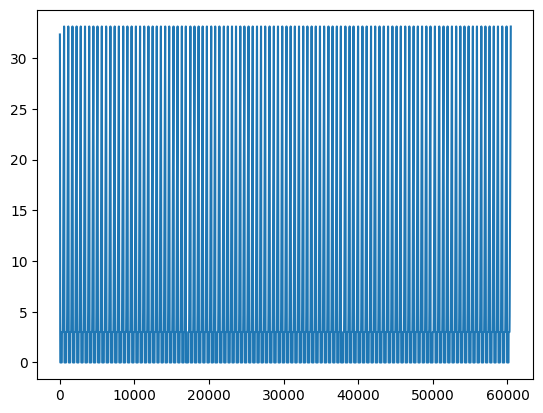

In [7]:
i = 20
plt.plot(data_list[2, grade_split_points[i]: grade_split_points[i+1]])
plt.show()

In [26]:
import pandas as pd

sample_points = [[] for _ in range(len(grade_split_points)-1)]
grade_count = 0
cut_off_count = 0

ROI_start, ROI_spain = 40, 10

for i in range(len(gait_split_points)):
    p = gait_split_points[i]
    if p > grade_split_points[-1]:
        break
    elif p < grade_split_points[0]:
        continue
    if grade_split_points[grade_count] <= p < grade_split_points[grade_count+1]:
        cut_off_count += 1
        if cut_off_count > 10:
            sample_points[grade_count].append(p)
    elif p >= grade_split_points[grade_count+1]:
        grade_count += 1
        cut_off_count = 1

sample_index = np.zeros((len(sample_points), ROI_spain, 30))

sample_angle = np.zeros((len(sample_points), ROI_spain, 30))
sample_velocity = np.zeros((len(sample_points), ROI_spain, 30))
sample_control = np.zeros((len(sample_points), ROI_spain, 4))

sample_ME = np.zeros((len(sample_points), ROI_spain))

valid_count = 0
for i in range(len(sample_points)):
    for j in range(ROI_spain+30):
        # iterate to get control law params
        if sample_points[i][j+ROI_start+1] - sample_points[i][j+ROI_start] >= 600 or valid_count >= ROI_spain:
            valid_count = 0
            break
              
        j = valid_count
        # print(i, ' , ', valid_count, ' , ', j)
        sample_index[i][j][:] = np.linspace(sample_points[i][j+ROI_start], sample_points[i][j+ROI_start+1], 30, dtype='int')
        target_torque = src_torque[sample_points[i][j+ROI_start]: sample_points[i][j+ROI_start+1]]
        target_len = sample_points[i][j+ROI_start+1] - sample_points[i][j+ROI_start]
        sample_control[i][j][1] = np.argmax(target_torque)
        sample_control[i][j][0] = src_torque[int(sample_control[i][j][1] + sample_points[i][j+ROI_start])] / 50
        for k in range(len(target_torque) - 2):
            if target_torque[k] == target_torque[k+1] == target_torque[k+2]:
                continue
            elif target_torque[k] == target_torque[k+1] < target_torque[k+2] and k/target_len < 0.5:
                sample_control[i][j][2] = k
            elif target_torque[k] > target_torque[k+1] == target_torque[k+2] and k/target_len > 0.3:
                sample_control[i][j][3] = k
        sample_control[i][j][1:4] = sample_control[i][j][1:4] / target_len

        # iterate to get meatbolic data form data_list
        sample_ME[i][j] = np.average(data_list[3][sample_points[i][j+ROI_start]: sample_points[i][j+ROI_start+1]])
        valid_count += 1

    valid_count = 0

sample_index = sample_index.astype('int')


# 数据标准化处理
sample_angle = data_list[0][sample_index]
sample_angle_normalized = sample_angle / np.max(abs(sample_angle))
sample_velocity = data_list[1][sample_index]
sample_velocity_normalized = sample_velocity / np.max(abs(sample_velocity))
sample_ME = sample_ME / np.max(sample_ME)

In [44]:
target_torque

array([ 0.        ,  0.        ,  0.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
        3.        ,  3.        ,  3.        ,  3.        ,  3.  

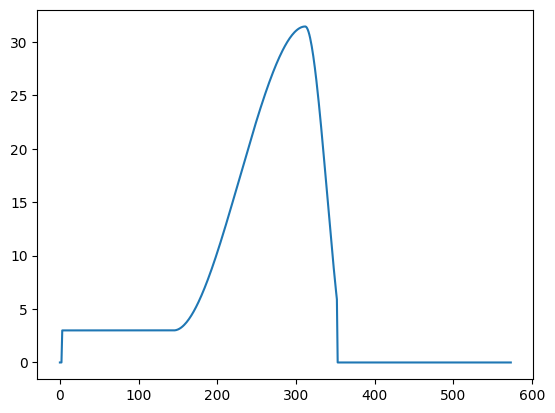

(574,)

In [51]:
plt.plot(target_torque)
plt.show()
target_torque.shape

In [49]:
# 准备数据
data_df = pd.DataFrame(target_torque)   #关键1，将ndarray格式转换为DataFrame

# # 更改表的索引
# data_df.columns = ['A','B','C','D','E','F','G','H','I','J']  #将第一行的0,1,2,...,9变成A,B,C,...,J
# data_df.index = ['a','b','c','d','e','f','g','h','i','j']


# 将文件写入excel表格中
writer = pd.ExcelWriter('hhh.xlsx')  #关键2，创建名称为hhh的excel表格
data_df.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.close()  #关键4

39545 40094
40094 40579
40579 41019
41019 41488
41488 42027
42027 42579
42579 43125
43125 43668
43668 44211
44211 44755
126818 127342
127342 127873
127873 128411
128411 128951
128951 129447
129447 129973
129973 130492
130492 131014
131014 131535
131535 132064
187258 187784
187784 188311
188311 188833
188833 189352
189352 189892
189892 190406
190406 190931
190931 191458
191458 191978
191978 192501
247939 248484
248484 249018
249018 249552
249552 250085
250085 250621
250621 251158
251158 251687
251687 252226
252226 252758
252758 253302
308433 308986
308986 309492
309492 310025
310025 310559
310559 311094
311094 311620
311620 312154
312154 312684
312684 313209
313209 313747
367903 368411
368411 368933
368933 369466
369466 369997
369997 370525
370525 371060
371060 371592
371592 372126
372126 372675
372675 373213
428693 429245
429245 429749
429749 430282
430282 430819
430819 431375
431375 431879
431879 432421
432421 432976
432976 433502
433502 434031
489843 490207
490207 490921
490921 49179

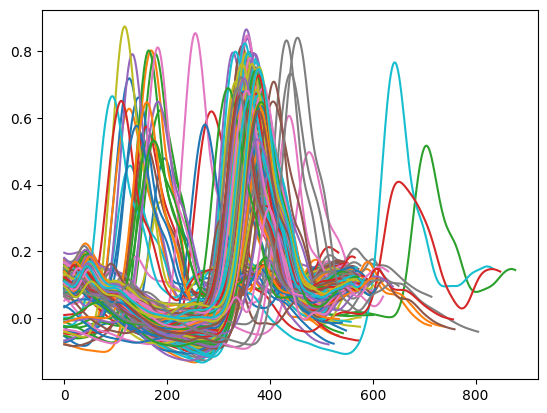

In [21]:
for i in range(len(sample_angle)):
    
    for j in range(ROI_spain):
        print(sample_points[i][j], sample_points[i][j+1])
        save_name = 'check_images/' + str(i) + ' , ' + str(j)
        plt.plot(data_list[0, sample_points[i][j]: sample_points[i][j+1]])
plt.savefig(save_name)

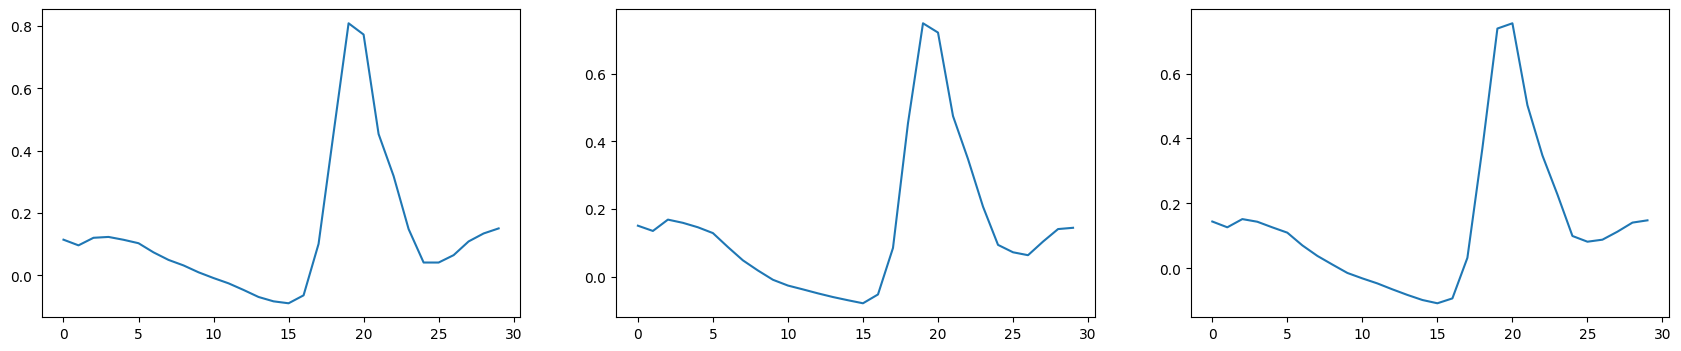

In [16]:
grade = 3

fig = plt.figure(num=3, figsize=[21, 4])
ax1 = fig.add_subplot(131)
ax1 = plt.plot(sample_angle[grade, 0, :])

ax2 = fig.add_subplot(132)
ax2 = plt.plot(sample_angle[grade, 1, :])

ax3 = fig.add_subplot(133)
ax3 = plt.plot(sample_angle[grade, 2, :])

plt.show()

In [17]:
aa = np.hstack((sample_angle_normalized.reshape(-1, 30), sample_velocity_normalized.reshape(-1, 30)))
bb = np.hstack((aa, sample_control.reshape(-1, 4)))
sample_65 = np.hstack((bb, sample_ME.reshape(-1, 1)))
sample_65 = sample_65.reshape(len(sample_index), ROI_spain, -1)
sample_65.shape

(22, 10, 65)

In [18]:
sample_65_shuffle = sample_65.copy()
np.random.shuffle(sample_65_shuffle)
print(sample_65[2][33][1:3])
print(sample_65_shuffle[2][33][1:3])

sample_input = sample_65_shuffle - sample_65


aa, bb = 4, 33
fig = plt.figure(num=3, figsize=[21, 4])
ax1 = fig.add_subplot(131)
ax1 = plt.plot(sample_input[aa][bb][0:30])
plt.ylim([-1, 1])

ax2 = fig.add_subplot(132)
ax2 = plt.plot(sample_input[aa][bb][30:60])
plt.ylim([-1, 1])

ax3 = fig.add_subplot(133)
ax3 = plt.plot(sample_input[aa][bb][60:64])
plt.ylim([-0.3, 0.3])

plt.show()

print(sample_input[aa][bb][64])

IndexError: index 33 is out of bounds for axis 0 with size 10

In [27]:
input_data = sample_input.reshape(-1, 65)
input_data[:, 0:64].shape

(1100, 64)

In [28]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#所使用数据集同上X，y
input_data = sample_input.reshape(-1, 65)
X = input_data[:, 0:64]
diff_ME = input_data[:, 64].squeeze()
fun_compare = lambda x : (x >= 0) * 1
compare_result = fun_compare(diff_ME)
y = compare_result.astype('int')


# 划分训练集和测试集#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建Logistic回归模型
logreg = LogisticRegression()

# 训练模型
logreg.fit(X_train, y_train)

# 预测测试集
y_pred = logreg.predict(X_test)

# 计算预测准确率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5181818181818182
